In [80]:
######################################
# DEPENDENCIES
######################################
import os
import math
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from random import randint
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

device:  cpu


## The Data
From the __[NASA Exoplanet archive](https://exoplanetarchive.ipac.caltech.edu/index.html)__, we have retrieved 3 data tables:
 - A table storing information relating to each exoplanet & its planetary system
 - A table storing information relating to the transit spectroscopy of exoplanet
 - A table storing information relating to the emission spectroscopy of exoplanet


In [2]:

#Raw Data Tables
systems_df = pd.read_csv('data/PS_2021.12.15_14.44.00.csv', sep=',', low_memory=False)

transitspec_df = pd.read_csv('data/transitspec_2021.10.21_17.04.26.csv', sep=',', low_memory=False)

emispec_df = pd.read_csv('data/emissionspec_2021.10.22_13.36.00.csv', sep=',', low_memory=False)

## Discovery Method
The most important and generalized information is stored in the "Planetary Systems" database, which we will be calling _systems_df_. This is general information about the discovery of the planets, what system they are from, and the most pertinant information about the exoplanet and system.

Notice that in this table, we have included the 'discovery method' column, as this is relevant to the interpretation of all other features. Particularly, notice that there is associated with the plantary mass a 'provenance', which indicates wether or not a planet's mass is given as a "True Mass" or as a lower bound on planetary mass, depending on the discovery method. 

We will stratify the data by its method of discovery, so that meaningful comparisons can be made between rows. One of the most common and successful discovery methods is the transit method, which refers to observations of a planet which passes directly in between it's host star and the viewer, altering the observed light effects:

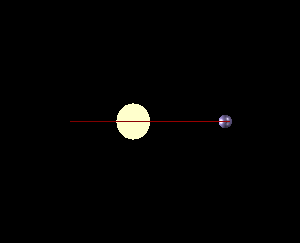

(image in public domain)

We will start by working on the data obtained by this method, and then move on to other popular methods such as Radial Velocity, Direct Imaging, or Microlensing. 



## General Purpose
- Create a program which can interpret a mixture of planetary and stellar data to classify planets into the categories of habitable and not habitable, based on pre-existing definitions garnered from what has been studies about life on Earth.
(The obvious problem with this model is that we know so little about life elsewhere in the cosmos.)

## Habitability Classification
In the preprocessing stage of our investigation, we shall determine the planets which fall within the following bounds to be "habitable." Planets which fail to meet any of these parameters will be considered not habitable.

Stellar Characteristics:
- Stellar Mass: 0.4 to 1.4 times the Sun’s mass 
- Types of habitable stars
    - Late F, G, to mid
- Temperature: Between 3000 and 7000 K
- Using Luminosity to determine habitable zone 
- (Actually, use absolute luminosity)
    - ri = √Lstar/1.1 (inner boundary of habitable zone)
    - r0 = √Lstar/0.53 (outer boundary of habitable zone)
    - link: https://www.planetarybiology.com/calculating_habitable_zone.html
- Than, based on these bounds, if orbit semi-major axis falls outside of these zones, not habitable
- Stellar Age: Stars formed between 11 and 3.8 billion years ago
    - Thus, valid age range lies between 3.8 and 11 billion years old
   

- Stellar Metallicity
    - Strongly affects the duration of the habitable zone, and the distance from the host star where duration is maximized 
    - General rule: Stars having significantly high-than-solar metallicity have a much longer duration of habitability at a given distance than do stars of lower-than-solar metallicity. Heavy elements are required for life to emerge, and stars without heavy metal presence were likely formed in the primordial stages of the universe. 
    - For a 1.0 M star (mass of the sun) w/ solar metallicity of 0.017 duration of habitable zone lasts for less than 10 billion years at 1.2 to 2.0 AU from the star
    - Duration is greater than 20 billion years for high-metallicity stars (0.070) at distances 0.7-1.8 AU
    - ~4 Billion years at distances of 1.8-3.3 AU for low-metallicity stars (0.0001)  
    - Paper: https://iopscience.iop.org/article/10.1088/0004-637X/769/1/27/pdf
    - We are already using the above equations to determine our "habitable" zones
    - As such, we will primarily use metallicity to characterize duration.
    - The characterization for metallicities effects depends widely on the other parameters, including stellar age, distance, and semi-major orbital axis. As such, for the purpose of this classification, stars that fall below the metallicity of 0 will be ruled as inhabitable. Any lower of a ratio would result in a lack of heavy elements sufficient to support complex biological structures. 
 


Planetary Characteristics
Orbital Eccentricity (a less certain parameter)
- Habitability model refers to obliquity, spin rate, orbital    eccentricity, and fraction of the surface covered by ocean
- Since so few of the planets have statistics for obliquity (true or projected) eccentricity is veritably useless)
- Equilibrium Temperature (no real known bounds on habitability)
- (HOWEVER, could classification find relationships? Include as features anyways?)

- Planetary Mass:
    - Must be at least 2.7 percent mass of Earth
    - Paper: https://iopscience.iop.org/article/10.3847/1538-4357/ab2bf2
    - Any smaller than 2.7 percent, and the planet will not be able to hold onto its atmosphere and water long enough for life to appear
    - Upper bound on Planetary mass: 5 𝑀⊕ (earth masses)

    

  


In [3]:
#ASK: what are the MOST ESSENTIAL features?
for col in systems_df.columns:
    print(col)

pl_name
discoverymethod
pl_controv_flag
pl_orbsmax
pl_msinie
pl_dens
pl_orbeccen
st_teff
st_rad
st_mass
st_met
st_lum
st_logg
st_age
st_dens


## Strata

In [4]:

#To avoid controversy, remove rows with nonzero 'controversial' flag
systems_df = systems_df[systems_df['pl_controv_flag'] == 0]
systems_df = systems_df.drop(columns = 'pl_controv_flag')

pl_systems_transit = systems_df[systems_df['discoverymethod'] == 'Transit']
print(f"num rows by Transit method: {len(pl_systems_transit)}")
#print(f"% default: {len(pl_systems_transit[pl_systems_transit['default_flag'] == 1])/len(pl_systems_transit)}")
#print(f"% of total default: {len(pl_systems_transit[pl_systems_transit['default_flag'] == 1])/total_default}\n")

pl_systems_radial = systems_df[systems_df['discoverymethod'] == 'Radial Velocity']
print(f"num rows by Radial Velocity method: {len(pl_systems_radial)}")
#print(f"% default: {len(pl_systems_radial[pl_systems_radial['default_flag'] == 1])/len(pl_systems_radial)}")
#print(f"% of total default: {len(pl_systems_radial[pl_systems_radial['default_flag'] == 1])/total_default}\n")

pl_systems_img = systems_df[systems_df['discoverymethod'] == 'Imaging']
print(f"num rows by Direct Imaging method: {len(pl_systems_img)}")
#print(f"% default: {len(pl_systems_img[pl_systems_img['default_flag'] == 1])/len(pl_systems_img)}")
#print(f"% of total default: {len(pl_systems_img[pl_systems_img['default_flag'] == 1])/total_default}\n")

pl_systems_microlens = systems_df[systems_df['discoverymethod'] == 'Microlensing']
print(f"num rows by Microlensing method: {len(pl_systems_microlens)}")
#print(f"% default: {len(pl_systems_microlens[pl_systems_microlens['default_flag'] == 1])/len(pl_systems_microlens)}")
#print(f"% of total default: {len(pl_systems_microlens[pl_systems_microlens['default_flag'] == 1])/total_default}\n")

pl_systems_eclipse = systems_df[systems_df['discoverymethod'] == 'Eclipse Timing Variations']
print(f"num rows by Eclipse Timing method: {len(pl_systems_eclipse)}")
#print(f"% default: {len(pl_systems_eclipse[pl_systems_eclipse['default_flag'] == 1])/len(pl_systems_eclipse)}")
#print(f"% of total default: {len(pl_systems_eclipse[pl_systems_eclipse['default_flag'] == 1])/total_default}\n")

pl_names = systems_df['pl_name']


num rows by Transit method: 29160
num rows by Radial Velocity method: 1996
num rows by Direct Imaging method: 101
num rows by Microlensing method: 342
num rows by Eclipse Timing method: 19


As we can see from the above calculations, the **Transit** method is the most common and popular, yet the least reliable, going by the readings which are flagged as 'default' for that particular exoplanet. On the other hand, Radial velocity, though less reliable than Direct Imaging, has a good amount of default readings, and also has a higher amount of features.

## Define our pipeline's inputs:

In [77]:
#define our inputs for the rest of the pipeline

#we don't need to look at name or discovery method
pl_names = pl_systems_transit['pl_name']
X = pl_systems_transit.iloc[:, 2:]
#X = np.log(X)
print(X)
print(pl_names)

       pl_orbsmax  pl_msinie  pl_dens  pl_orbeccen  st_teff  st_rad  st_mass  \
139       0.06600    57.2094     4.40        0.100   3700.0    0.75     0.50   
140       0.06450        NaN     1.40        0.000   3700.0    0.75     0.50   
141       0.11010        NaN     2.30        0.000   3700.0    0.75     0.50   
151       0.24100        NaN     7.89        0.000   5766.0    0.93     0.96   
152           NaN        NaN      NaN        0.000   5766.0    1.08     1.67   
...           ...        ...      ...          ...      ...     ...      ...   
31715     0.08150        NaN     0.62        0.000   6720.0    1.93     1.47   
31716     0.04421        NaN     0.34        0.038   6250.0    1.48     1.41   
31773         NaN        NaN      NaN          NaN   5950.0    1.15      NaN   
31774     0.06839        NaN     2.97        0.000   6037.0    1.10     1.09   
31775     0.06702        NaN     2.82        0.000   5870.0    1.10     1.02   

       st_met  st_lum  st_logg  st_age 

## Gaussian Mean and Variance

In [6]:
pl_systems_transit_mean = pl_systems_transit.mean();

print(f"mean of data:\n {pl_systems_transit_mean} \n")

print("covariance among key features:")
print(pl_systems_transit.cov())

print("\ncorrelation among key features:")
print(pl_systems_transit.corr())



mean of data:
 pl_orbsmax        0.133293
pl_msinie       361.635202
pl_dens           2.385181
pl_orbeccen       0.010203
st_teff        5476.864776
st_rad            1.035229
st_mass           0.940837
st_met           -0.041167
st_lum           -0.149143
st_logg           4.433061
st_age            4.607545
st_dens           3.118583
dtype: float64 

covariance among key features:
             pl_orbsmax      pl_msinie     pl_dens  pl_orbeccen  \
pl_orbsmax     0.022523       4.380596    0.019052    -0.000045   
pl_msinie      4.380596  310698.841097  -63.233371    12.469896   
pl_dens        0.019052     -63.233371   17.471951     0.031478   
pl_orbeccen   -0.000045      12.469896    0.031478     0.002948   
st_teff       14.766393  313274.369620 -469.910152    -0.935737   
st_rad         0.005425      67.698467   -0.313687     0.001721   
st_mass        0.003431      76.101023   -0.200014     0.000830   
st_met        -0.002750       1.732370   -0.086266     0.001451   
st_lum    

/var/folders/r0/_3y3kj9d09350r_smmnsxfqw0000gn/T/ipykernel_15394/1835096694.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pl_systems_transit_mean = pl_systems_transit.mean();


## Imputation
Because this dataset contains a significant amount of missing values, we will experiment with imputing the missing values, in order to avoid throwing away whole planet rows. We will be taking an iterative approach in order to capture more of the complexity of the data in our imputed values, and to avoid altering the shape of the overall distribution as much as possible. 
Note that the imputation process somewhat normalizes the distribution of values in each feature, as

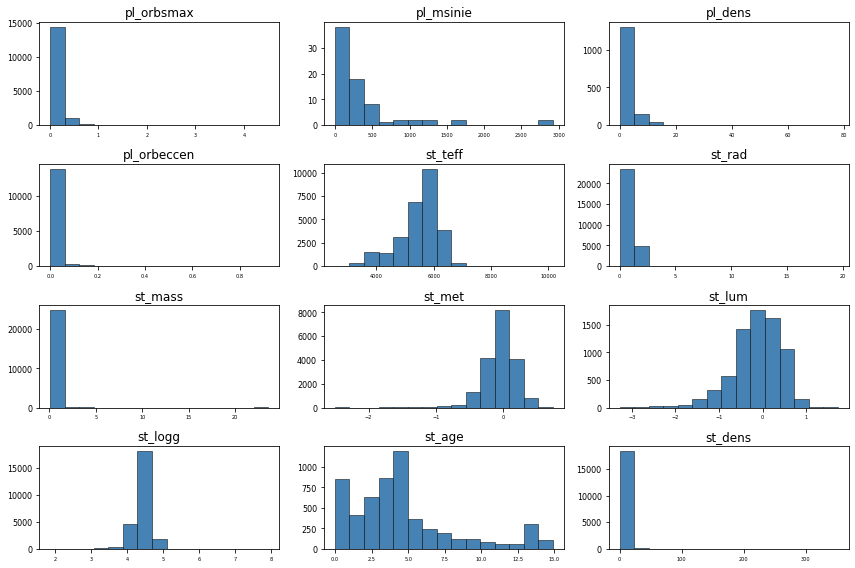

/Users/benjaminirving/Desktop/ds4400/venv/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


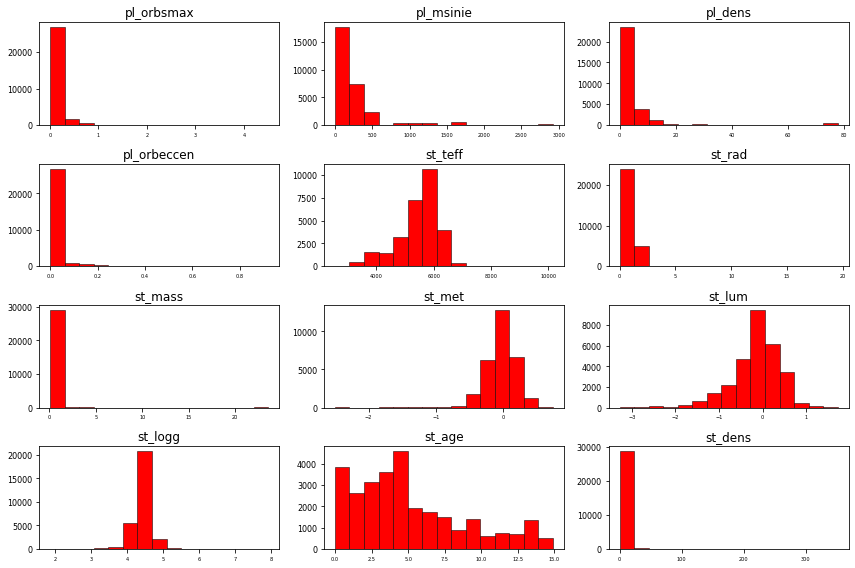

In [78]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeRegressor # had the best results with this.
estim = DecisionTreeRegressor(max_features="sqrt", random_state=0)

X.hist(bins=15, color='steelblue', edgecolor='black', linewidth=0.5,
           xlabelsize=5, ylabelsize=8, grid=False)  
plt.tight_layout(rect=(0, 0, 2, 2))   
plt.show()

imp = IterativeImputer(estimator=estim, max_iter=100, n_nearest_features=11, imputation_order='ascending', add_indicator=False)

#fit the model
imp.fit(X)
    
#impute missing values
imp_results = imp.transform(X)

X = pd.DataFrame(imp_results, columns=X.columns, index=pl_names)

X.hist(bins=15, color='red', edgecolor='black', linewidth=0.5, xlabelsize=5, ylabelsize=8, grid=False)

plt.tight_layout(rect=(0, 0, 2, 2))   
plt.show()
    
#These plots should look as similar as possible


Looks pretty good!

In [8]:
#X

## Our own Habitability metric

In [9]:
earth_mass = systems_df[(systems_df['pl_msinie'] > 0.257) & (systems_df['pl_msinie'] < 5)]
valSun = earth_mass[(earth_mass['st_teff'] > 2300) & (earth_mass['st_teff'] < 7600)]
# the error may be in the habitable zone calculation

# If the semi-major orbital axis takes the planet beyond these zones,
# we will not classify the planet as habitable.

# represents the systems data that has luminosity values

# Stellar mass: 0.4 < x < 1.4 (in Sun masses)
systems_df_4 = X[X['st_mass'] > 0.4]
systems_df_5 = systems_df_4[systems_df_4['st_mass'] < 1.6]

# Luminosity (will be used in the following calculation)
# Stellar luminosity is just 1
#ri = √Lstar/1.1 (inner boundary of habitable zone)
#r0 = √Lstar/0.53 (outer boundary)
systems_inner_bound = systems_df_5['st_logg']/1.1 ** 1/2
systems_outer_bound = systems_df_5['st_logg']/0.53 ** 1/2
# now, we have to ensure that the semi-major orbital axis
# falls within thse parameters to find the "habitable" planets
# orbsmax
# valid_semi_major
valid_orbit = systems_df_5[(systems_df_5['pl_orbsmax'] > systems_inner_bound)&(systems_df_5['pl_orbsmax'] < systems_outer_bound)]
# When it falls between these age ranges

# valid orbit is messed up
# Stellar Age: between 3.8 and 11 billion years old
valid_age = systems_df_5[(systems_df_5['st_age'] > 3.8) & (systems_df_5['st_age'] < 11)]
# stellar metallicity: greater than 0
# the bound that we are accepting as the range of habitability
valmet = valid_age[(valid_age['st_met'] > 0)]

# the largest terrestrial planet in the galaxy has a mass of 17 Earth
# Masses
valid_mass = valmet[(valmet['pl_msinie'] > 0.25) & (valmet['pl_msinie'] < 17)]
# reupload the table with only the filled in values, missing values
# must be imputed. So systems_df_3 takes from perfect table
systems_not_habitable = pd.concat([systems_df,valid_mass]).drop_duplicates(keep=False)

# We then divide these features into training and test data
# We take random subset of positive answers, and we label them
# as x training data

# training data for habitable planets
x_train_habitable = valid_mass.sample(n=(math.ceil(len(valid_mass)*(2/3))))
y_train_habitable = np.ones(len(x_train_habitable))

# training data for uninhabitable planets
x_train_uninhabitable = systems_not_habitable.sample(n=(math.ceil(len(systems_not_habitable) * 2/3)))
y_train_uninhabitable = np.zeros(len(x_train_uninhabitable))

# test data for habitable planets
x_test_habitable = pd.concat([valid_mass, x_train_habitable]).drop_duplicates(keep=False)
y_test_habitable = np.ones(len(x_test_habitable))

# test data for uninhabitable
x_test_uninhabitable = pd.concat([systems_not_habitable,x_train_uninhabitable]).drop_duplicates(keep=False)
y_test_uninhabitable = np.zeros(len(x_test_uninhabitable))


## The Habitable Exoplanets Catalog

There exists, of course, much active and ongoing discourse within the astrobiology community on what is the appropriate severity with which to discriminate when determining the boundaries for the vague class that is "potentially habitable exoplanets". Nevertheless, this is the great question that many are investigating, and the most widely referenced list of these potentially habitable worlds comes from the Planetary Habitability Lab at the University of Puerto Rico Arecibo (https://phl.upr.edu/projects/habitable-exoplanets-catalog), which divides the results into a conservative list of potential exoplanets, and an optimistic list. 

From this, we may divide the data into three classes:
 - [1] Potentially earth-like (optimistically)
 - [2] Unlikely earth-like (all others)
 
The more specific criteria for these classes and some interesting information about each of the planets in classes 1 and 2 can be found at the link above.

In [46]:

# multiple readings on same data
PHE_conservative = ['Teegarden\'s Star b', 'TOI-700 d', 'Kepler-1649 c', 'TRAPPIST-1 d', 'Proxima Cen b',  'K2-72 e', 'GJ, 1061 d', 'GJ 1061 c', 'Ross 128 b', 'GJ 273 b', 'Kepler-269 e', 'TRAPPIST-1 e', 'Kepler-442 b', 'GJ 667 C f', 'Kepler-62 f', 'TRAPPIST-1 f', 'Teegarden\'s Star c', 'Kepler-1229 b', 'Kepler-186 f', 'GJ 667 C e', 'TRAPPIST-1 g']
PHE_optimistic = ['Kepler-452 b', 'Kepler-62 e', 'Kepler-1652 b', 'Wolf 1061 c', 'Kepler-1410 b', 'GJ 667 C c', 'Kepler-1544 b', 'Kepler-283 c', 'Kepler-1638 b', 'Kepler-440 b', 'GJ 443 d', 'Kepler-1653 b', 'GJ 832 c', 'Kepler-705 b', 'K2-332 b', 'Kepler-155 c', 'TOI-2257 b', 'Kepler-443 b', 'Kepler-22 b', 'Kepler-1701 b', 'K2-18 b', 'Kepler-1606 b', 'K2-9 b', 'GJ 180 c', 'GJ 163 c', 'Kepler-1540 b', 'Kepler-174 d', 'HD 40307 g', 'Kepler-296 f', 'HIP 38594 b', 'K2-288 B b', 'HD 216520 c', 'GJ 3293 d', 'LHS 1140 b', 'GJ 229 A c', 'GJ 357 d', 'GJ 682 b', 'GJ 180 d']


#The habitability class
Y = {}
y = []

p = 0
for name in pl_names:
    if name in PHE_conservative or name in PHE_optimistic:
        Y[name] = 1;
        y.append(1)
        p+=1
    else:
        Y[name] = 0;
        y.append(0)
        
print(p)


38
21
248


## Earth Similarity Index (ESI)

Another popular (and again somewhat subjective) measure of supposed habitability among researchers is the concept of a Earth Similarity Index, which is a function of a planet's stellar flux and radius, given by the function 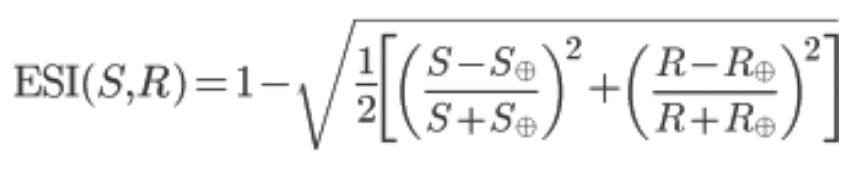
With this Information, we may be able to perform more nuanced analysis of the data available to us.

In [11]:
esi_info = pd.read_csv('data/data_extrasolar_ESI.txt', sep="\ [\ ]+", engine='python') 

esi_info

,Planet,mass,radius,density,g,ve,a,Tsurf,Teq,ESIi,ESIs,ESIg
0,GJ 581 g,3.100,1.36,1.22,1.67,1.51,0.15,278.0,248.0,0.901,0.877,0.889
1,GJ 581 d,5.600,1.60,1.36,2.18,1.87,0.22,232.0,202.0,0.849,0.643,0.739
2,GJ 581 c,5.600,1.60,1.36,2.18,1.87,0.07,380.0,350.0,0.849,0.583,0.703
3,HD 69830 d,18.434,3.36,0.49,1.63,2.34,0.63,312.0,282.0,0.636,0.747,0.689
4,55 Cnc f,45.768,4.91,0.39,1.90,3.06,0.78,310.0,280.0,0.536,0.703,0.614
...,...,...,...,...,...,...,...,...,...,...,...,...
254,OGLE-TR-56 b,413.181,13.47,0.17,2.28,5.54,0.02,2074.0,2044.0,0.291,0.013,0.061
255,CoRoT-1 b,327.367,16.72,0.07,1.17,4.43,0.03,1765.0,1735.0,0.180,0.020,0.060
256,HAT-P-7 b,572.097,15.95,0.14,2.25,5.99,0.04,1981.0,1951.0,0.256,0.014,0.060
257,WASP-17 b,155.738,19.53,0.02,0.41,2.83,0.05,1533.0,1503.0,0.092,0.032,0.054


## Our Solar System

There is actually one datapoint that we can confidently label as 'habitable' and that is our home system of the sun, and our home planet of earth. Once we have discovered the underlying distribution of all other exoplanet systems, this information may be used to create a discrete classification for exoplanets that seem to be in a similar ballpark.

In [12]:


#define these same features for our sun (source: Wikipedia)
EARTH_MASS = 1

SUN_MASS = 1
SUN_MET = 0.0122
SUN_TEFF = 5772



In [13]:
from sklearn.decomposition import KernelPCA, FactorAnalysis

## Kernel PCA
The next step will be to try to use simple generative linear models to obtain insights on the nature of the data. We will start by performing principal component analysis with a selection of various common kernel functions.

Latent space from PCA, linear kernel: 
[[-1757.19317441   277.84302344]
 [-1723.70934131   404.10754869]
 [-1769.72848415   230.5680975 ]
 ...
 [  458.27745195  -145.58042323]
 [  584.81454009    -7.82301599]
 [  330.76063332  -314.34459157]]



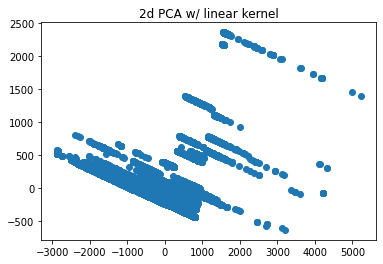

Latent space from PCA, polynomial kernel: 
[[-2.89617116e+09  4.91622786e+08]
 [-2.87579157e+09  5.60580845e+08]
 [-2.90372153e+09  4.66242058e+08]
 ...
 [ 8.80510009e+08 -3.01901475e+08]
 [ 1.16909540e+09 -1.19829940e+08]
 [ 6.07947822e+08 -5.12136056e+08]]



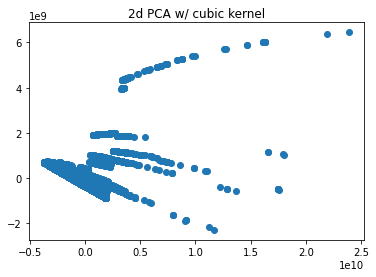

Latent space from PCA, rbf kernel: 
[[-0.00722118 -0.00151506]
 [-0.00722118 -0.00151506]
 [-0.00723159 -0.00152684]
 ...
 [-0.00767437 -0.00214462]
 [-0.00772302 -0.00237919]
 [-0.00797031 -0.00280589]]



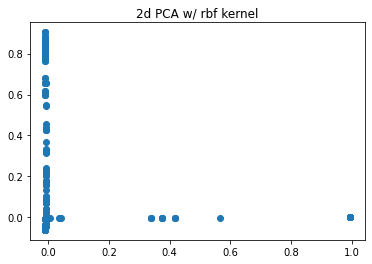

Latent space from PCA, cosine kernel: 
[[-0.02475116  0.00108152]
 [ 0.01034653 -0.00232384]
 [-0.03787062  0.00262739]
 ...
 [-0.00406845 -0.00111491]
 [ 0.02268243 -0.00321783]
 [-0.03671709  0.00247172]]



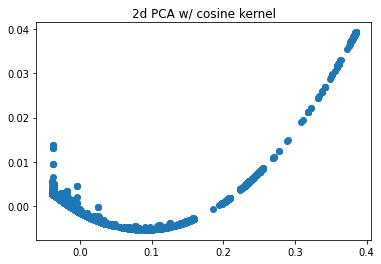

In [14]:
#PCA

kpca = KernelPCA(n_components=2, kernel='linear') 
kpca.fit(X);
X_kpca = kpca.transform(X)

print(f"Latent space from PCA, linear kernel: \n{X_kpca}\n")

plt.title('2d PCA w/ linear kernel')
plt.scatter(X_kpca[:,0], X_kpca[:,1])
plt.show()

kpca = KernelPCA(n_components=2, kernel='poly', degree=3) #increasing degree of poly kernel seems to reduce variance.
kpca.fit(X);
X_kpca = kpca.transform(X)

print(f"Latent space from PCA, polynomial kernel: \n{X_kpca}\n")

plt.title('2d PCA w/ cubic kernel')
plt.scatter(X_kpca[:,0], X_kpca[:,1])
plt.show()

kpca = KernelPCA(n_components=2, kernel='rbf') 
kpca.fit(X);
X_kpca = kpca.transform(X)

print(f"Latent space from PCA, rbf kernel: \n{X_kpca}\n")

plt.title('2d PCA w/ rbf kernel')
plt.scatter(X_kpca[:,0], X_kpca[:,1])
plt.show()


kpca = KernelPCA(n_components=2, kernel='cosine') 
kpca.fit(X);
X_kpca = kpca.transform(X)

print(f"Latent space from PCA, cosine kernel: \n{X_kpca}\n")

plt.title('2d PCA w/ cosine kernel')
plt.scatter(X_kpca[:,0], X_kpca[:,1])
plt.show()

## Neural Network
Here, we use a basic feed-foward Neural Network to learn the habitability classification for planets. 

In [15]:
# network will use binary classification, either "habitable" or not
class NN(nn.Module):
    def __init__(self, n_layers, hidden_size, activations):
        
        super().__init__()
        assert len(hidden_size) > 0
        
        # valid activation functions to choose from
        act = {'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh(), 'relu': nn.ReLU(),'identity': nn.Identity()}
        self.layers = []
        
        
        for i in range(n_layers - 1):
            # hidden size i will be number of input neurons'
            # hidden size i + 1 will be number of neurons to send signals to
            self.layers.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
            
            # if activations[i] in act?
            if activations[i] in act:
                self.layers.append(act[activations[i]])
            else:
                assert activations in ['sigmoid', 'tanh', 'relu', 'identity']
                
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        for idx in range(len(self.layers) - 1):
            x = self.layers[idx](x)
        return x
    
    

In [16]:
def train(model, optimizer, criterion, n_epoch, data, label):
    
    # // signals floor division
    print_iteration = n_epoch//5
    
    # data will be the x_training data as a tensor
    data = torch.tensor(data, dtype=torch.float).to(device)
    
    # label will be the y_training data as a tensor
    label = torch.tensor(label, dtype=torch.long).squeeze().to(device)
    
    
    for epoch in range(n_epoch):
        
        # should we predict in batches of data
        predict = model(data)
        
        
        optimizer.zero_grad()
        
        # the loss function should be tuned
        loss = criterion(predict, label)
        
        loss.backward()
        
        optimizer.step()
        
    if epoch%print_iteration == 0:
        print('epoch: ', epoch, '\tloss: ', loss.item())
        
    print('epoch: ', epoch, '\tloss: ', loss.item())
    return model.named_parameters

In [17]:
def model_accuracy(data, label):
    data = torch.tensor(data, dtype=torch.float).to(device)
    predict = model(data)
    predict = torch.argmax(predict, dim=-1).cpu().detach().numpy()
    acc = accuracy_score(predict, label)
    return acc, predict

In [18]:

# We have to refine the plot function. We are working in higher
# dimensions, so in terms of fitting the data to a reasonable axis,
# we want to represent what is going on

# how do we want to plot our results?
# we can decide to plot specific groups of features against the y values

def plot_data(x, y, xt, model, title=''):
    x_lin = np.linspace(-5, 5, 2000)
    y_lin = np.linspace(-3, 2, 2000)
    
    x_plot = np.array([(x, y) for x in x_lin for y in y_lin])
    x_plot_tensor = torch.tensor(x_plot, dtype=torch.float).to(device)
    y_plot_tensor = model(x_plot_tensor)
    y_plot = torch.argmax(y_plot_tensor, dim=-1).cpu().detach().numpy()
    
    c1_plot = np.argwhere(y_plot == 1)
    c1_plot = x_plot[c1_plot].squeeze()
    c0_plot = np.argwhere(y_plot == 0)
    c0_plot = x_plot[c0_plot].squeeze()
    
    plt.scatter(c1_plot[:, 0], c1_plot[:, 1], c='cyan', alpha=0.5)
    plt.scatter(c0_plot[:, 0], c0_plot[:, 1], c='yellow', alpha=0.5)
    
    xt = torch.tensor(xt, dtype=torch.float).to(device)
    yt = model(xt)
    yt = torch.argmax(yt, dim=-1).cpu().detach().numpy()
    
    c1t = np.argwhere(yt == 1)[:, 0]
    c1t = xt[c1t].cpu().detach().numpy().squeeze()
    c0t = np.argwhere(yt == 0)[:, 0]
    c0t = xt[c0t].cpu().detach().numpy().squeeze()
    
    plt.scatter(c1t[:, 0], c1t[:, 1], c='blue', marker='s', label='test: Habitable')
    plt.scatter(c0t[:, 0], c0t[:, 1], c='red', marker='o', label='test: Not Habitable')
    
    c1 = np.argwhere(y == 1)[:, 0]
    c1 = x[c1].squeeze()
    c0 = np.argwhere(y == 0)[:, 0]
    c0 = x[c0].squeeze()
    
    plt.scatter(c1[:, 0], c1[:, 1], c='lavender', marker='.', s=0.5,label='train: Habitable')
    plt.scatter(c0[:, 0], c0[:, 1], c='darkslategrey', marker='.', s=0.5,label='train: Not Habitable')
    
    plt.legend(loc=4, fontsize = 'x-small') # prop={'size': 6})
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

In [19]:

Kernel_pca = KernelPCA(n_components=2, kernel='cosine') 
Kernel_pca.fit(X);


In [119]:
# now, we have to prepare these for the neural network to process them

# to add to the data:
# Earth (on repeat)
# The model will learn to predict 0, due to the heavy imbalance
# So what we should do instead is balance the data

#pl_name
#discoverymethod
#pl_controv_flag
#pl_orbsmax
#pl_msinie
#pl_dens
#pl_orbeccen
#st_teff
#st_rad
#st_mass
#st_met
#st_lum
#st_logg
#st_age
#st_dens



# rebuild the data from the ground up
earth_data = [1, 1, 5.51, 0.01671, 5780, 1, 1, 0.012, 1, 2.43, 4.6, 1.41]

earths_to_add = []
for a in range(10000):
    earths_to_add.append(earth_data)


# add these to training and test data
earths_to_add = [earth_data] * 10000
earths_y = [1] * 10000

# so, add this to the end of the training data
earths = np.array([earth_data] * 10000)

# the first 0.70 of the data
x_train_df = X.head(int(len(X)*(70/100))) 

x_train = x_train_df.to_numpy()
y_train = y[0:len(x_train)]

x_test_df = X.tail(int(len(X)*(30/100)))
x_test = x_test_df.to_numpy()
y_test = y[len(y_train):]



x_hab = []

for u in range(len(y_train)):
    if(y_train[u] == 1):
        x_hab.append(x_train[u])


# randomly duplicate samples in the minority class
for x in range(5000):
    value = randint(0, len(x_hab) - 1)
    x_train = np.append(x_train, x_hab[value])
i = 0
j = 0
x_train_actual = []
while(i<len(x_train)):
    k = []
    j = 0
    while(j < 12):
        k.append(x_train[i])
        j+=1
        i+=1
    x_train_actual.append(k)


for x in range(5000):
    value = randint(0, len(x_hab)  - 1)
    x_test = np.append(x_test, x_hab[value])
z = 0
x_test_actual = []
while(z<len(x_test)):
    p = []
    x = 0
    while(x < 12):
        p.append(x_test[x])
        x+=1
        z+=1
    x_test_actual.append(p)


while(len(y_train) < len(x_train_actual)):
    y_train.append(1)

    
while(len(y_test) < len(x_test_actual)):
    y_test.append(1)
    

# 248 positive values

# 10000 positive examples
# so, 19160 negative examples
print(x_train_actual)

[[0.066, 57.2094, 4.4, 0.1, 3700.0, 0.75, 0.5, -0.13, -1.046, 4.63, 0.022, 3.3806], [0.0645, 66.10864, 1.4, 0.0, 3700.0, 0.75, 0.5, -0.19999999999999998, -1.046, 4.63, 0.022, 0.1568], [0.1101, 66.10864, 2.3, 0.0, 3700.0, 0.75, 0.5, -0.19999999999999998, -1.046, 4.63, 0.022, 0.1568], [0.241, 20.0, 7.89, 0.0, 5766.0, 0.93, 0.96, -0.15, -0.056, 4.5, 3.34, 1.7], [0.076, 92.48853, 2.7, 0.0, 5766.0, 1.08, 1.67, -0.15, 0.053000000000000005, 4.5, 2.1, 1.89], [0.0915, 92.48853, 2.34, 0.0, 5703.0, 0.96, 0.96, -0.06, -0.021, 4.38, 4.17, 0.1152], [0.0261, 870.8542, 0.8, 0.0, 5950.0, 1.14, 1.03, -0.1, 0.129, 4.35, 4.9, 0.953], [0.0275, 297.17105, 0.38, 0.0, 5950.0, 1.11, 0.95, -0.3, 0.435, 4.25, 9.9, 22.992499999999996], [0.02536, 870.8542, 0.344, 0.0, 5950.0, 1.13, 0.95, -0.3, 0.165, 4.31, 7.8, 0.93], [0.02752, 381.396, 0.302, 0.036, 6298.0, 1.23, 1.22, 0.06, 0.312, 4.3500000000000005, 1.6, 1.0039], [0.0259, 870.8542, 0.44, 0.071, 5950.0, 1.32, 1.07, -0.3, 0.246, 4.25, 7.8, 0.7511], [0.1055, 14.4,

In [122]:

#x_train_actual = abs(x_train_actual)
#x_train_actual = np.log(x_train_actual)
#x_train_actual = np.absolute(x_train_actual)

# reduce magnitude of the difference in the data
x_train_actual = np.divide(x_train_actual, 10)
x_test_actual = np.divide(x_test_actual, 10)


## Running the Model

In [124]:
n_epoch = 1000
learning_rate = 0.1

# want to train the network using different assortments of settings
settings = {
# one hidden layer. The initial layer will have a size of the 
# features we intend to read from
    
# why is the number of neurons in the last layer 2?
'hidden layer = 1, neuron = 11': {'hs': [12, 5, 2], 'act': ['relu','relu', 'sigmoid']},
'hidden layers = 3, neuron = 11,11,11': {'hs': [12, 11, 12, 11, 2], 'act':['relu', 'relu', 'relu', 'relu', 'sigmoid']},
'3': {'hs': [12, 12, 24, 12, 2], 'act':['relu', 'relu', 'relu', 'relu', 'sigmoid']},}
for setting in settings:
    print('---------------- Setting -------------------')
    print(setting)
    
    n_layers = len(settings[setting]['hs'])
    hidden_size = settings[setting]['hs']
    activations = settings[setting]['act']
    model = NN(n_layers, hidden_size, activations).to(device)
    
    # change for imbalanced data 
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = optim.Adadelta(model.parameters())

    # how do these weights actually affect the shape of the
    # data? 
    # determine better class weights:
    # Scaling by total/2 helps keep the loss to a similar magnitude.
    # The sum of the weights of all examples stays the same
    
    

    # alternative weight setting:
    # value of the largest class, divided by the size of the
    # current class
    weight_for_0 = 1.0
    weight_for_1 = 19160/10000

    class_weights = torch.tensor([weight_for_0, weight_for_1])
    criterion = nn.CrossEntropyLoss(weight = class_weights)
    
    #criterion = nn.CrossEntropyLoss()
    #criterion = nn.MSELoss()
    
    print('--------------- Training -------------------')
    param = train(model, optimizer, criterion, n_epoch, x_train_actual, y_train)
    print('Train Accuracy: ', model_accuracy(x_train_actual, y_train))
    
    print('--------------- Testing -------------------')
    accuracy, predict = model_accuracy(x_test_actual, y_test)
    print('Test Accuracy: ', model_accuracy(x_test_actual, y_test))
    
    
    print('------------------ Plot -------------------')
    
    #before calling this function, we should reduce data to two dimensions
    #plot_data(x_train, y_train, x_test, model, title=setting)
    print('\n')


---------------- Setting -------------------
hidden layer = 1, neuron = 11
--------------- Training -------------------
epoch:  999 	loss:  0.5295587778091431
Train Accuracy:  (0.8197701873130805, array([0, 0, 0, ..., 0, 0, 1]))
--------------- Testing -------------------
Test Accuracy:  (0.6302007564736689, array([0, 0, 0, ..., 0, 0, 0]))
------------------ Plot -------------------


---------------- Setting -------------------
hidden layers = 3, neuron = 11,11,11
--------------- Training -------------------
epoch:  999 	loss:  0.48494085669517517
Train Accuracy:  (0.8262631827483079, array([1, 1, 1, ..., 1, 1, 1]))
--------------- Testing -------------------
Test Accuracy:  (0.6302007564736689, array([0, 0, 0, ..., 0, 0, 0]))
------------------ Plot -------------------


---------------- Setting -------------------
3
--------------- Training -------------------
epoch:  999 	loss:  0.5131253600120544
Train Accuracy:  (0.7995435227451597, array([1, 1, 1, ..., 1, 1, 1]))
---------------